In [6]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from tqdm import tqdm
from pandas.tseries.offsets import BDay

plt.style.use("bmh")

In [17]:
bar_name = "Close"
vol_window = 90
resample_freq = "D"
vol_target = 10

capital = 1000
instruments = ["USDBRL=X", "EURUSD=X", "EURNOK=X"]

In [18]:
bars = []
vols = []
rets = []
for instrument in instruments:
    instrument_info = yf.Ticker(instrument)
    hist = instrument_info.history(period="max")[[bar_name]].resample(resample_freq).ffill().dropna()
    hist.index = pd.to_datetime([dtref.strftime("%Y-%m-%d") for dtref in hist.index])

    bars.append(hist.rename(columns={bar_name: "{instrument} {bar_name}".format(instrument=instrument, bar_name=bar_name)}))
    vols.append((hist.rolling(window=vol_window).std() / np.sqrt(252)).rename(columns={bar_name: "{instrument} daily vol%".format(instrument=instrument)}))
    rets.append(hist.pct_change().rename(columns={bar_name: "{instrument} ret%".format(instrument=instrument)}))

bars_df = pd.concat(bars, axis=1).resample(resample_freq).ffill().dropna()
vols_df = pd.concat(vols, axis=1).resample(resample_freq).ffill().dropna()
rets_df = pd.concat(rets, axis=1).resample(resample_freq).ffill().dropna()

<AxesSubplot:>

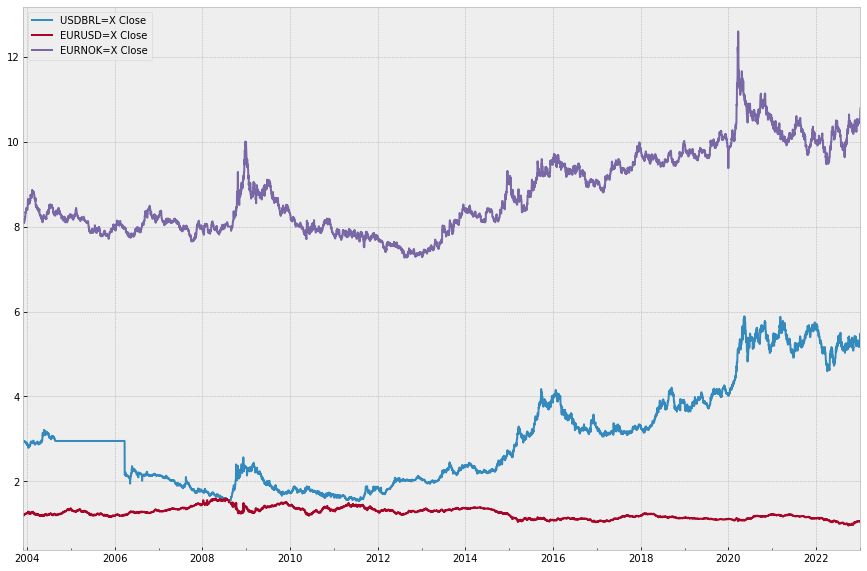

In [19]:
bars_df.plot(figsize=(15, 10))

In [4]:
signals = []
forecasts = []
for instrument in instruments:
    target_name = "{instrument} {bar_name}".format(instrument=instrument, bar_name=bar_name)

    tmp_signals = pd.DataFrame((bars_df[target_name] - bars_df[target_name].rolling(window=200).mean()).values,
                                columns=["{instrument} Signal".format(instrument=instrument)],
                                index=bars_df.index)
    signals.append(tmp_signals)
    
    tmp_forecasts = (bars_df[target_name] - bars_df[target_name].rolling(window=200).mean())
    tmp_forecasts = pd.DataFrame(np.where(tmp_forecasts > 0, 1, -1),
                                 columns=["{instrument} Forecasts".format(instrument=instrument)],
                                 index=bars_df.index)
    forecasts.append(tmp_forecasts)

signals_df = pd.concat(signals, axis=1)
forecasts_df = pd.concat(forecasts, axis=1)

In [81]:
backtest_dates = signals_df.dropna().index
portfolio_df = pd.DataFrame(index=backtest_dates)

first_day = True
for t in tqdm(backtest_dates, desc="Running Backtest", total=len(backtest_dates)):

    nominal_total = 0
    nominal_ret = 0
    pnl = 0
    for inst in instruments:
        
        if first_day:
            portfolio_df.loc[t, "capital"] = capital
            portfolio_df.loc[t, "{} position units".format(inst)] = 0
            portfolio_df.loc[t, "{} leverage".format(inst)] = 0
        else:
            # separate all inputs needed for the calculation
            price_change = bars_df.loc[t, "{} Close".format(inst)] - bars_df.loc[t - dt.timedelta(1), "{} Close".format(inst)]
            price = bars_df.loc[t, "{} Close".format(inst)] 
            previous_capital = portfolio_df.loc[t - dt.timedelta(1), "capital"]
            inst_daily_ret_vol = vols_df.loc[t, "{} daily vol%".format(inst)] / 100
            forecast = forecasts_df.loc[t, "{} Forecasts".format(inst)]
            previos_positions_units = portfolio_df.loc[t - dt.timedelta(1), "{} units".format(inst)]

            # compute pnl of last positions
            if previos_positions_units != 0:
                dollar_change = price_change * 1 #FX Conversion, for now assume all USD
                inst_pnl = dollar_change * portfolio_df.loc[t, "{} position units".format(inst)]
                pnl += inst_pnl
                nominal_ret += portfolio_df.loc[t - dt.timedelta(1), "{} w".format(inst)] * rets_df.loc[t, "{} ret%".format(inst)]

            # compute position vol. target in th currency and the instrument daily vol. in the currency
            position_vol_target = (previous_capital / len(inst)) * (vol_target / 100) * (1 / np.sqrt(252))
            inst_daily_price_vol = price * inst_daily_ret_vol
            position_units = forecast * position_vol_target / inst_daily_price_vol 

            portfolio_df.loc[t, "{} position units".format(inst)] = position_units
            nominal_total += abs(position_units * bars_df.loc[t, "{} Close".format(inst)])
    
    portfolio_df.loc[t, "nominal"] = nominal_total
    portfolio_df.loc[t, "leverage"] = nominal_total / portfolio_df.loc[t, "capital"]
    
    first_day = False

Running Backtest: 100%|██████████| 8583/8583 [00:04<00:00, 1801.89it/s]


In [88]:
(last_capital / len(inst)) 

nan